# Big G Express: Predicting Derates
In this project, you will be working with fault code data and vehicle onboard diagnostic data to try and predict an upcoming full derate. These are indicated by an SPN 5246. 

You have been provided with a two files containing the data you will use to make these predictions (J1939Faults.csv and VehicleDiagnosticOnboardData.csv) as well as two files describing some of the contents (DataInfo.docx and Service Fault Codes_1_0_0_167.xlsx) 

Note that in its raw form the data does not have "labels", so you must define what labels you are going to use and create those labels in your dataset. Also, you will likely need to perform some significant feature engineering in order to build an accurate predictor.

There are service locations at (36.0666667, -86.4347222), (35.5883333, -86.4438888), and (36.1950, -83.174722), so you should remove any records in the vicinity of these locations, as fault codes may be tripped when working on the vehicles.

When evaluating the performance of your model, assume that the cost associated with a missed full derate is approximately $4000.00$ in towing and repairs, and the cost of a false positive prediction is about $500 due to having the truck off the road and serviced unnecessarily.

A failed component is usually what triggers this code.

Common Failures

 * Failed DEF doser valve
 * Associated fault code: SPN 5394
 * You ran out of DEF fluid
 * Associated fault code: SPN 5392, SPN 1761
 * Inlet and Outlet NOx sensors failed, not making pressure
 * Associated fault code: SPN 4094
 * EGR system malfunction causing NOX efficiency problems
 * DEF pump failed, not making pressure
 * Associated fault code: SPN 4334, SPN 4339
 * DEF module has failed or DEF harness failure or no power to DEF module causes DEF gauge to be empty and showing datalink error and SCR malfunction.
 * The DEF / ECM could also need updating to eliminate ghost codes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno 
from shapely.geometry import Point
import folium
import geopandas as gpd

In [2]:
faults = pd.read_csv("../data/J1939Faults.csv", low_memory=False)
faults.head(2)

,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,spn,fmi,active,activeTransitionCount,faultValue,EquipmentID,MCTNumber,Latitude,Longitude,LocationTimeStamp
0,1,990349,2015-02-21 10:47:13.000,Low (Severity Low) Engine Coolant Level,NaN,unknown,unknown,unknown,unknown,0,111,17,True,2,NaN,1439,105354361,38.857638,-84.626851,2015-02-21 11:34:25.000
1,2,990360,2015-02-21 11:34:34.000,NaN,NaN,unknown,unknown,unknown,unknown,11,629,12,True,127,NaN,1439,105354361,38.857638,-84.626851,2015-02-21 11:35:10.000


In [3]:
#load diagnostics data
diagnostics = pd.read_csv("../data/VehicleDiagnosticOnboardData.csv")
diagnostics.head(2)

,Id,Name,Value,FaultId
0,1,IgnStatus,False,1
1,2,EngineOilPressure,0,1


In [4]:
#drop unnecessary columns
columns_to_drop = ['ESS_Id', 'actionDescription', 'ecuSoftwareVersion', 'ecuSerialNumber', 'ecuModel', 'ecuMake', 'ecuSource', 'faultValue', 'MCTNumber']
faults_a = faults.drop(columns=columns_to_drop)

# fix data types
faults_a['EventTimeStamp'] = pd.to_datetime(faults_a['EventTimeStamp'])
faults_a['LocationTimeStamp'] = pd.to_datetime(faults_a['LocationTimeStamp'])

In [5]:
faults_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1187335 entries, 0 to 1187334
Data columns (total 11 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   RecordID               1187335 non-null  int64         
 1   EventTimeStamp         1187335 non-null  datetime64[ns]
 2   eventDescription       1126490 non-null  object        
 3   spn                    1187335 non-null  int64         
 4   fmi                    1187335 non-null  int64         
 5   active                 1187335 non-null  bool          
 6   activeTransitionCount  1187335 non-null  int64         
 7   EquipmentID            1187335 non-null  object        
 8   Latitude               1187335 non-null  float64       
 9   Longitude              1187335 non-null  float64       
 10  LocationTimeStamp      1187335 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](2), float64(2), int64(4), object(2)
memory usage: 91.7+ MB


In [6]:
# function to categorize time of day
def categorize_time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Night'
    else:
        return 'Early'

In [7]:
# Apply the function to create a new column for time of day
faults_a['time_of_day'] = faults_a['EventTimeStamp'].dt.hour.apply(categorize_time_of_day)

In [8]:
faults_a['EquipmentID']=faults_a['EquipmentID'].str.extract('(\d+)')

In [9]:
faults_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1187335 entries, 0 to 1187334
Data columns (total 12 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   RecordID               1187335 non-null  int64         
 1   EventTimeStamp         1187335 non-null  datetime64[ns]
 2   eventDescription       1126490 non-null  object        
 3   spn                    1187335 non-null  int64         
 4   fmi                    1187335 non-null  int64         
 5   active                 1187335 non-null  bool          
 6   activeTransitionCount  1187335 non-null  int64         
 7   EquipmentID            1187335 non-null  object        
 8   Latitude               1187335 non-null  float64       
 9   Longitude              1187335 non-null  float64       
 10  LocationTimeStamp      1187335 non-null  datetime64[ns]
 11  time_of_day            1187335 non-null  object        
dtypes: bool(1), datetime64[ns](2

In [10]:
def categorize_time_of_day(hour):
    if faults_a.spn <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Night'
    else:
        return 'Early'

In [11]:
faults_a.head()


,RecordID,EventTimeStamp,eventDescription,spn,fmi,active,activeTransitionCount,EquipmentID,Latitude,Longitude,LocationTimeStamp,time_of_day
0,1,2015-02-21 10:47:13,Low (Severity Low) Engine Coolant Level,111,17,True,2,1439,38.857638,-84.626851,2015-02-21 11:34:25,Morning
1,2,2015-02-21 11:34:34,NaN,629,12,True,127,1439,38.857638,-84.626851,2015-02-21 11:35:10,Morning
2,3,2015-02-21 11:35:31,Incorrect Data Steering Wheel Angle,1807,2,False,127,1369,41.421250,-87.767361,2015-02-21 11:35:26,Morning
3,4,2015-02-21 11:35:33,Incorrect Data Steering Wheel Angle,1807,2,True,127,1369,41.421018,-87.767361,2015-02-21 11:36:08,Morning
4,5,2015-02-21 11:39:41,NaN,4364,17,False,2,1674,38.416481,-89.442638,2015-02-21 11:39:37,Morning


In [12]:
faults_merged = pd.merge(faults_a, diagnostics.pivot(index='FaultId', columns='Name', values='Value'), 
                     left_on='RecordID',right_on= 'FaultId',how='left')

In [13]:
faults_merged.head()

,RecordID,EventTimeStamp,eventDescription,spn,fmi,active,activeTransitionCount,EquipmentID,Latitude,Longitude,...,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure
0,1,2015-02-21 10:47:13,Low (Severity Low) Engine Coolant Level,111,17,True,2,1439,38.857638,-84.626851,...,NaN,False,78.8,1023,True,NaN,0,3276.75,NaN,0
1,2,2015-02-21 11:34:34,NaN,629,12,True,127,1439,38.857638,-84.626851,...,NaN,True,NaN,1279,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2015-02-21 11:35:31,Incorrect Data Steering Wheel Angle,1807,2,False,127,1369,41.421250,-87.767361,...,NaN,NaN,NaN,1279,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2015-02-21 11:35:33,Incorrect Data Steering Wheel Angle,1807,2,True,127,1369,41.421018,-87.767361,...,NaN,True,NaN,1279,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2015-02-21 11:39:41,NaN,4364,17,False,2,1674,38.416481,-89.442638,...,NaN,NaN,NaN,16639,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
faults_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1187335 entries, 0 to 1187334
Data columns (total 36 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   RecordID                   1187335 non-null  int64         
 1   EventTimeStamp             1187335 non-null  datetime64[ns]
 2   eventDescription           1126490 non-null  object        
 3   spn                        1187335 non-null  int64         
 4   fmi                        1187335 non-null  int64         
 5   active                     1187335 non-null  bool          
 6   activeTransitionCount      1187335 non-null  int64         
 7   EquipmentID                1187335 non-null  object        
 8   Latitude                   1187335 non-null  float64       
 9   Longitude                  1187335 non-null  float64       
 10  LocationTimeStamp          1187335 non-null  datetime64[ns]
 11  time_of_day                1187335 no

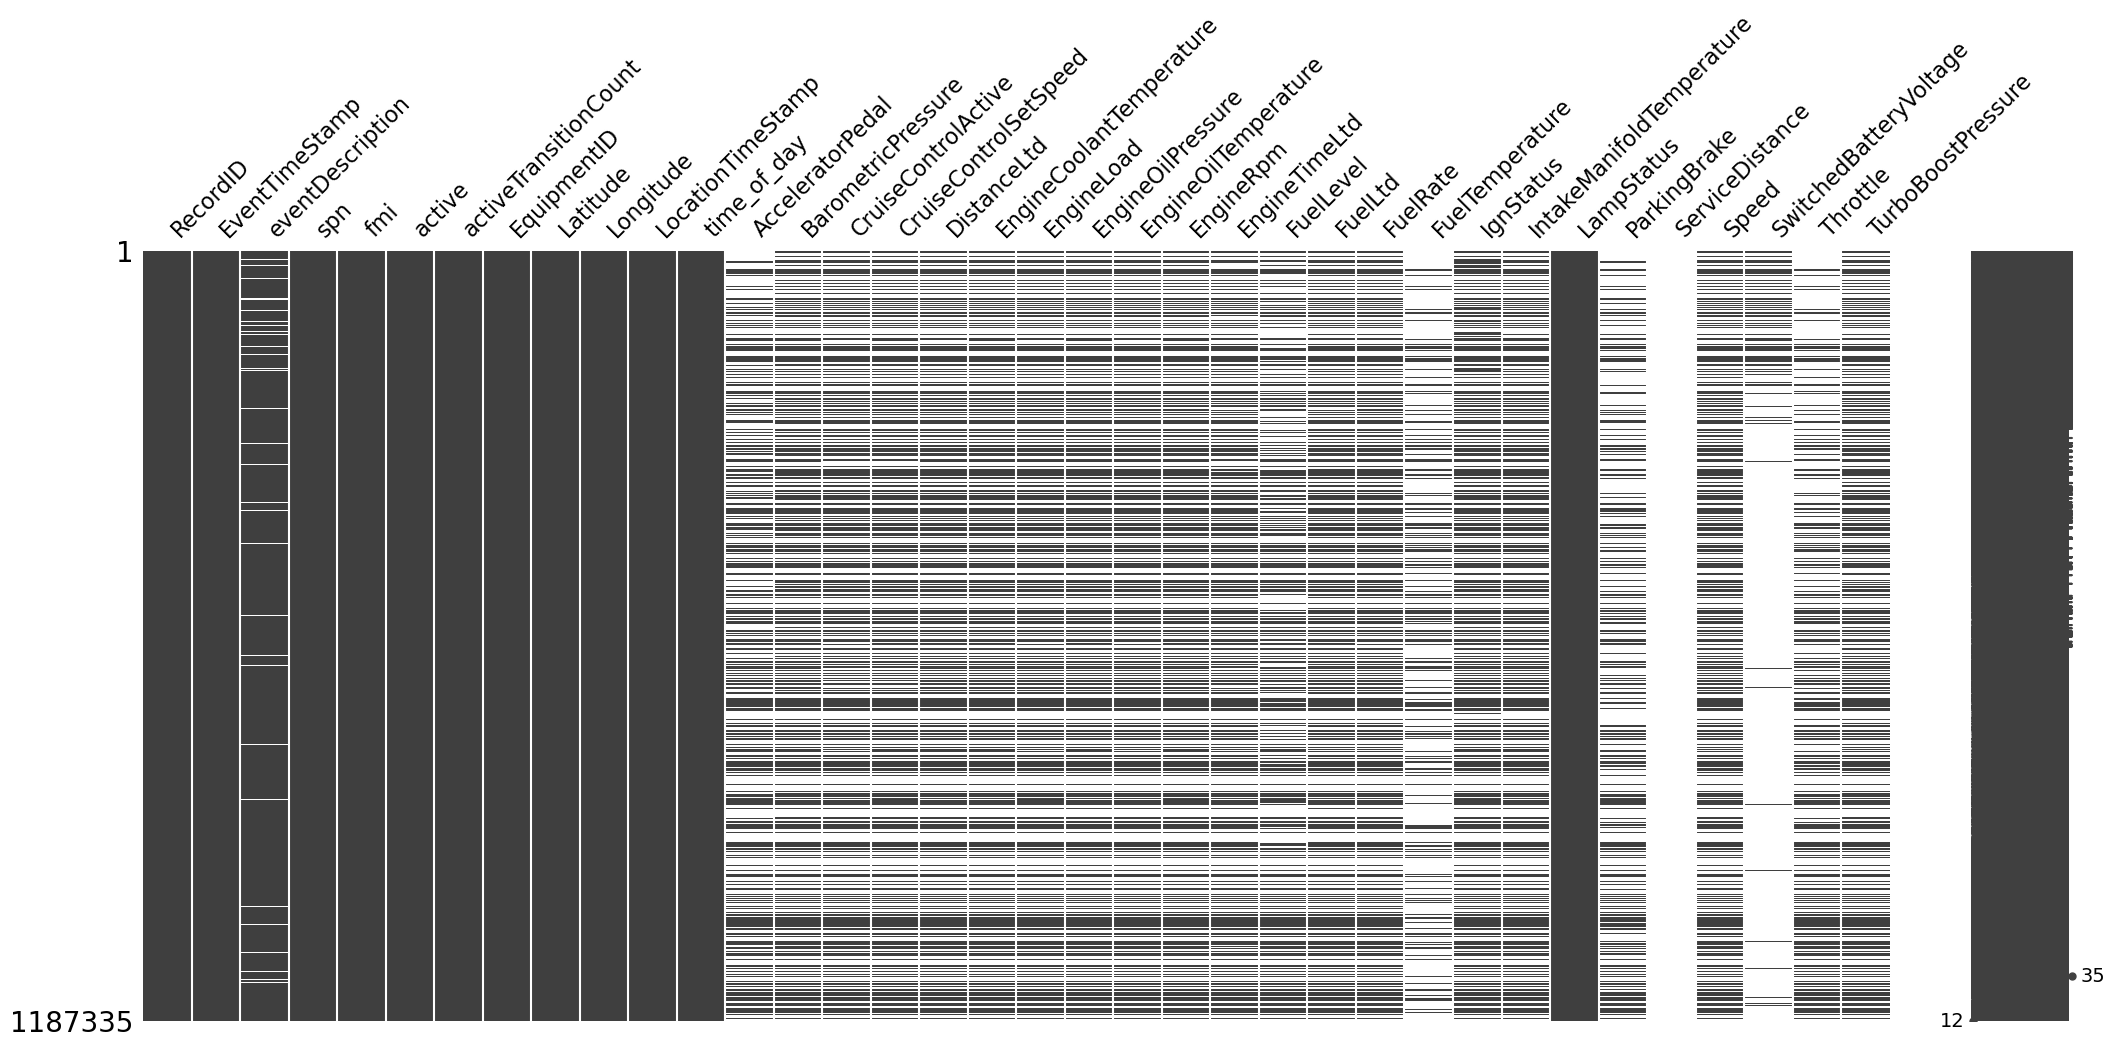

In [15]:
msno.matrix(faults_merged);

In [16]:
# drop all columns with active==False
faults_merged = faults_merged.drop(faults_merged[faults_merged.active == False].index)

In [17]:
#drop noncritical columns...
faults_merged=faults_merged.drop(columns=['eventDescription',
                                          'AcceleratorPedal',
                                          'FuelLevel',
                                          'FuelTemperature',
                                          'SwitchedBatteryVoltage',
                                          'eventDescription',
                                          'AcceleratorPedal',
                                          'FuelTemperature',
                                          'SwitchedBatteryVoltage',
                                          'ServiceDistance',
                                          'ParkingBrake',
                                          'Throttle'])

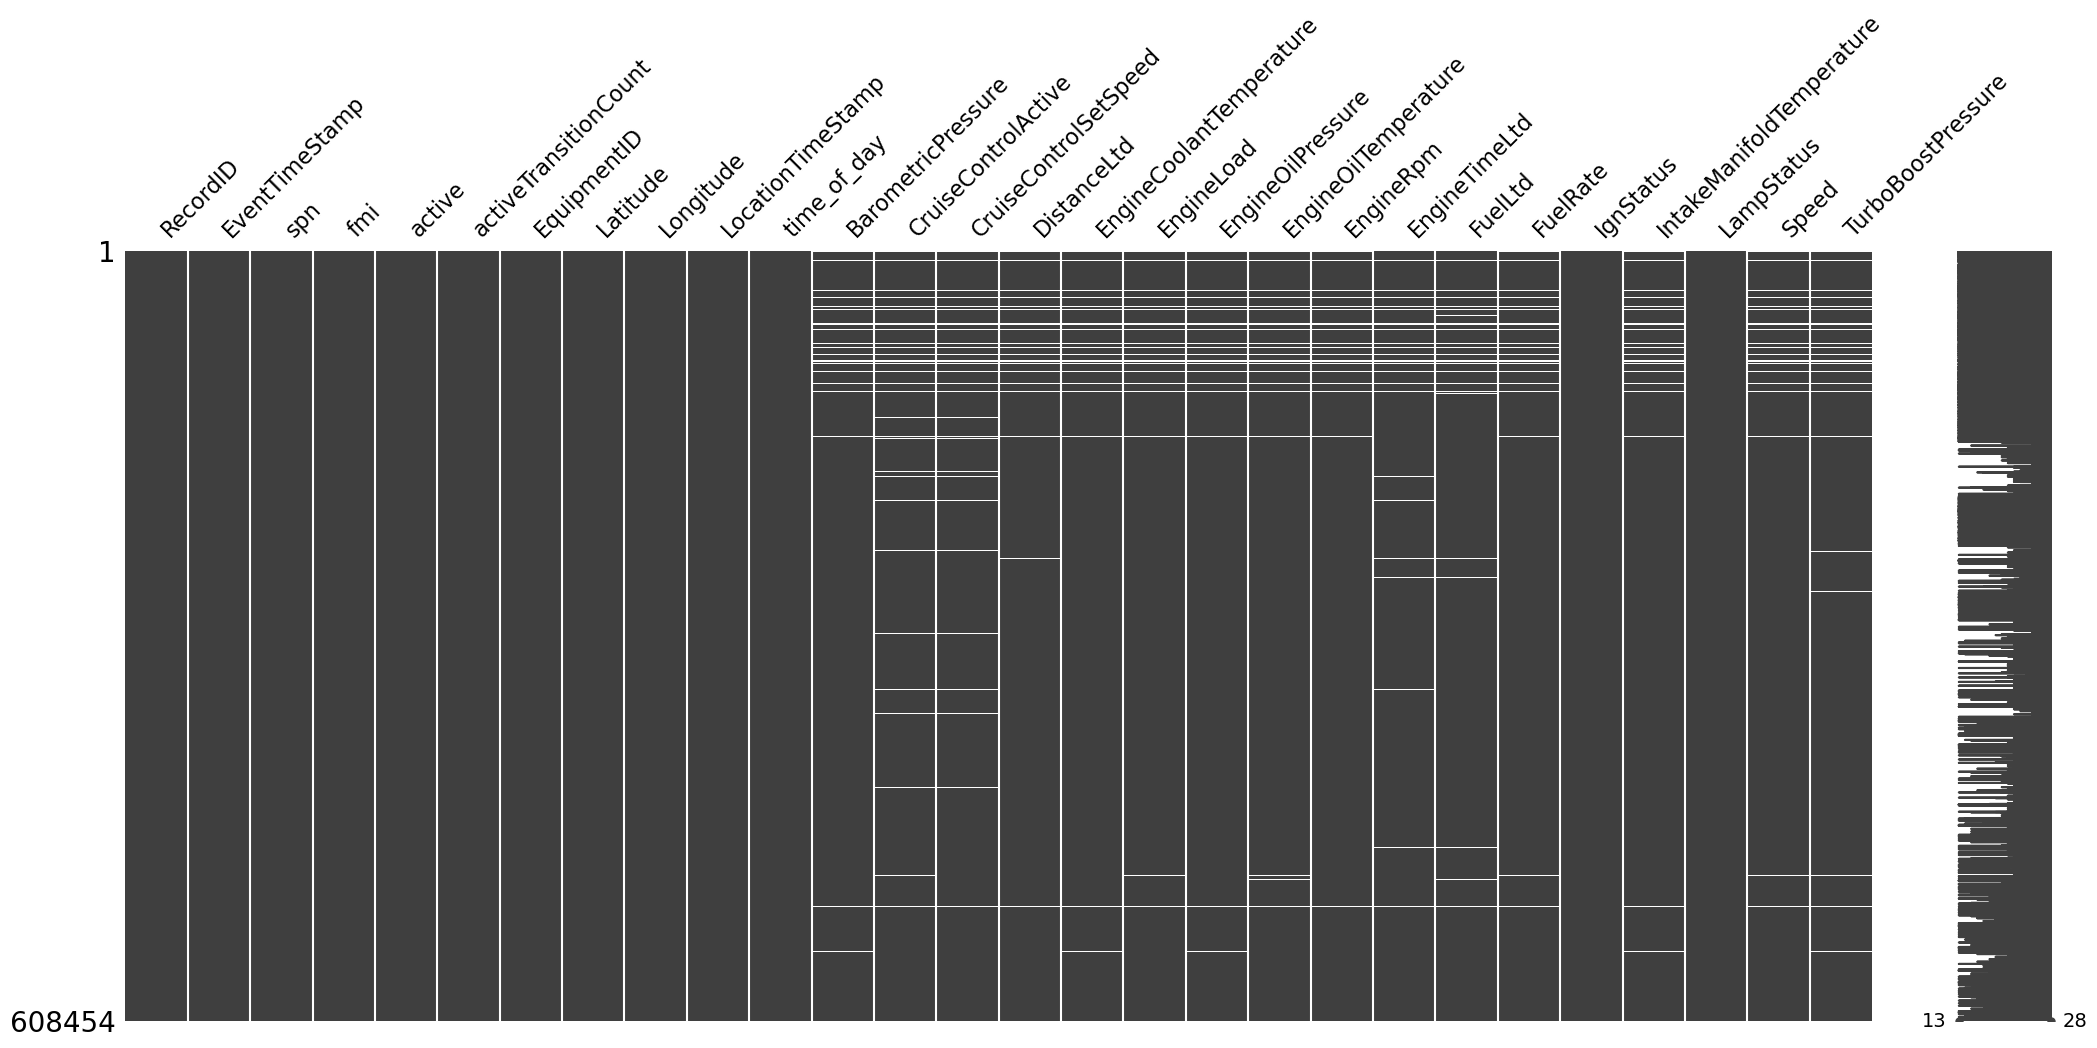

In [18]:
#check columns for nan's
msno.matrix(faults_merged);

In [19]:
#intermediate save
faults_merged.to_csv('../data/faults_merged.csv')

In [20]:
#Take out service centers using geo dataframe, pt1
faults_merged['geometry'] = gpd.points_from_xy(
    faults_merged['Longitude'], 
    faults_merged['Latitude']
    )

faults_merged_geo = gpd.GeoDataFrame(
    faults_merged, 
    crs = {'init':'epsg:4326'}, 
    geometry = faults_merged['geometry']
    )
#create service center geo dataframe
service_centers = [
    (36.0666667, -86.4347222), 
    (35.5883333, -86.4438888), 
    (36.1950, -83.174722)
    ]  # latitude and longitude coordinates for service centers

faults_merged_geo.to_crs(epsg = 3310, inplace = True)

C:\Users\micha\anaconda3\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [21]:
#Take out service centers using geo dataframe, pt 2
#create service center geo dataframe
service_centers = [
    (36.0666667, -86.4347222), 
    (35.5883333, -86.4438888), 
    (36.1950, -83.174722)
    ]  # latitude and longitude coordinates for service centers

service_centers_geo = [Point(lon, lat) for lat, lon in service_centers]
# same as before
service_centers_geo_df = gpd.GeoDataFrame(geometry=service_centers_geo, crs={'init':'epsg:4326'})
service_centers_geo_df.to_crs(epsg = 3310, inplace = True)


# now we want to filter dataframe to exclude data within 5 miles of all service center locations
distance_threshold = 5*1.609*1000 #meters

# Iterate over each point of interest
def filter(df,point):
    df['distance'] = df['geometry'].distance(point['geometry'])
    filtered_df = df[df['distance'] >= distance_threshold]
    return filtered_df

for index, row in service_centers_geo_df.iterrows():
    faults_merged_geo = filter(faults_merged_geo, row)
    
# this dataframe has all data but within 5 miles of service center locations
faults_merged_geo.head(2)

C:\Users\micha\anaconda3\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,RecordID,EventTimeStamp,spn,fmi,active,activeTransitionCount,EquipmentID,Latitude,Longitude,LocationTimeStamp,...,EngineTimeLtd,FuelLtd,FuelRate,IgnStatus,IntakeManifoldTemperature,LampStatus,Speed,TurboBoostPressure,geometry,distance
0,1,2015-02-21 10:47:13,111,17,True,2,1439,38.857638,-84.626851,2015-02-21 11:34:25,...,1632.2,12300.907429328,0,False,78.8,1023,0,0,POINT (2995931.113 658983.439),322511.478329
1,2,2015-02-21 11:34:34,629,12,True,127,1439,38.857638,-84.626851,2015-02-21 11:35:10,...,NaN,NaN,NaN,True,NaN,1279,NaN,NaN,POINT (2995931.113 658983.439),322511.478329


In [22]:
faults_merged_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 538934 entries, 0 to 1187333
Data columns (total 30 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   RecordID                   538934 non-null  int64         
 1   EventTimeStamp             538934 non-null  datetime64[ns]
 2   spn                        538934 non-null  int64         
 3   fmi                        538934 non-null  int64         
 4   active                     538934 non-null  bool          
 5   activeTransitionCount      538934 non-null  int64         
 6   EquipmentID                538934 non-null  object        
 7   Latitude                   538934 non-null  float64       
 8   Longitude                  538934 non-null  float64       
 9   LocationTimeStamp          538934 non-null  datetime64[ns]
 10  time_of_day                538934 non-null  object        
 11  BarometricPressure         521400 non-null  obje

In [23]:
faults_merged_geo=faults_merged_geo.round(2)

In [24]:
faults_merged_geo=faults_merged_geo.dropna()

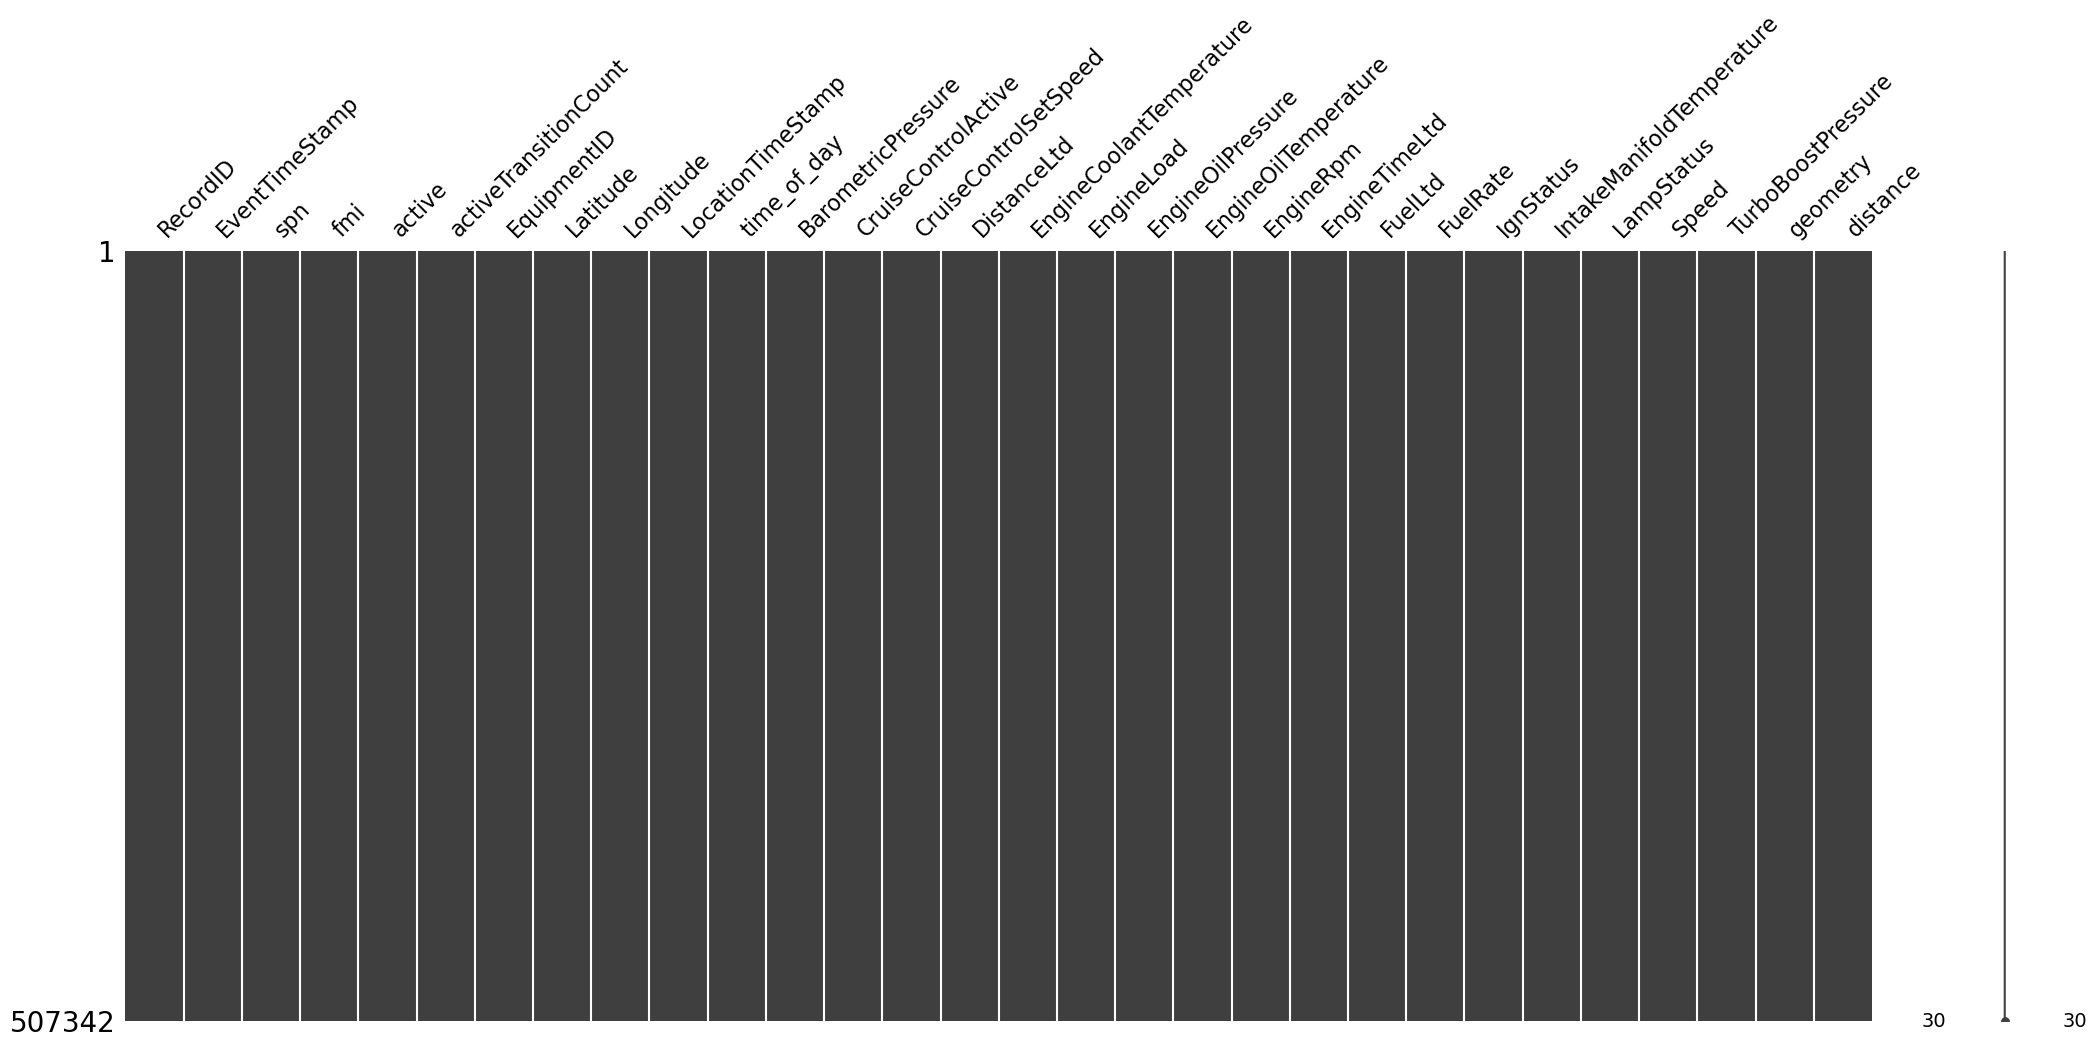

In [25]:
msno.matrix(faults_merged_geo);

In [26]:
faults_merged_geo

,RecordID,EventTimeStamp,spn,fmi,active,activeTransitionCount,EquipmentID,Latitude,Longitude,LocationTimeStamp,...,EngineTimeLtd,FuelLtd,FuelRate,IgnStatus,IntakeManifoldTemperature,LampStatus,Speed,TurboBoostPressure,geometry,distance
0,1,2015-02-21 10:47:13,111,17,True,2,1439,38.86,-84.63,2015-02-21 11:34:25,...,1632.2,12300.907429328,0,False,78.8,1023,0,0,POINT (2995931.113 658983.439),322511.48
5,6,2015-02-21 11:40:22,111,17,True,1,1417,33.04,-96.18,2015-02-21 11:40:59,...,9480,70349.809963756,4.583399,True,111.2,1023,13.6022,6.67,POINT (2203912.076 -273868.781),1241142.92
6,7,2015-02-21 11:40:52,111,17,True,2,1597,36.90,-86.44,2015-02-21 11:41:29,...,6292.2,40961.065436834,14.29175,True,78.8,1023,41.53478,20.59,POINT (2924633.056 399381.744),302008.99
10,11,2015-02-21 11:42:19,111,17,True,1,1582,40.16,-80.15,2015-02-21 11:42:55,...,5085.35,37724.957799834,13.72378,True,78.8,1023,64.82649,17.69,POINT (3294822.680 940816.032),513749.92
14,15,2015-02-21 11:14:38,1067,2,True,127,309,36.18,-86.70,2015-02-21 11:44:52,...,1308.9,9487.342989502,0,True,100.4,1279,26.31119,0.58,POINT (2930614.391 316197.313),316187.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187324,1248448,2020-03-06 13:12:43,96,3,True,126,1936,30.38,-81.74,2020-03-06 13:29:33,...,8016.75,51466.131256666,0.6208063,True,120.2,1279,0.9417657,1.16,POINT (3596452.948 -111435.441),658190.15
1187328,1248452,2020-03-06 13:42:48,111,18,True,93,1886,39.02,-77.03,2020-03-06 13:43:24,...,13047.05,64491.926796682,0.5151371,True,104,2047,5.932153,0.58,POINT (3591159.731 939093.066),625659.55
1187331,1248455,2020-03-06 14:04:23,1569,31,True,5,1994,34.39,-79.46,2020-03-06 14:04:59,...,10722.7,58979.184415546,7.647805,True,98.6,18431,65.01096,7.83,POINT (3614058.524 381823.677),392368.52
1187332,1248456,2020-03-06 14:13:38,3216,10,True,1,1850,34.43,-84.92,2020-03-06 14:14:14,...,9326.75,65080.10587046,8.995086,True,91.4,17407,66.5741,6.96,POINT (3150103.060 191097.240),252099.59


In [27]:
#intermediate save
faults_merged_geo.to_csv('../data/faults_merged_pt1_done.csv')

In [28]:
#continued in Big-G_pipeline_pt2...